In [10]:
from pytket.pauli import Pauli, QubitPauliString
from pytket.circuit import Qubit, PauliExpBox, Circuit
from pytket.utils import QubitPauliOperator
from pytket.extensions.qiskit import AerBackend
import openfermion as of
from pytket.transform import Transform

import numpy as np
import matplotlib.pyplot as plt

`PauliExpBox` (implementing $e^{-\frac{1}{2} i \pi a (\sigma_0 \otimes \sigma_1 \otimes \cdots)}$ for arbitrary Pauli operators $\sigma_i \in \{\mathrm{I}, \mathrm{X}, \mathrm{Y}, \mathrm{Z}\}$ and parameter $a$).

In [11]:
pauli_sym = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}

In [12]:
def qps_from_openfermion(paulis):
    """Convert OpenFermion tensor of Paulis to pytket QubitPauliString."""
    qlist = []
    plist = []
    for q, p in paulis:
        qlist.append(Qubit(q))
        plist.append(pauli_sym[p])
    return QubitPauliString(qlist, plist)

def qpo_from_openfermion(openf_op):
    """Convert OpenFermion QubitOperator to pytket QubitPauliOperator."""
    tk_op = dict()
    for term, coeff in openf_op.terms.items():
        string = qps_from_openfermion(term)
        tk_op[string] = coeff
    return QubitPauliOperator(tk_op)

In [14]:
hamiltonian = QubitPauliOperator(
    {
        QubitPauliString([Qubit(0)], [Pauli.Z]): 0.1,
        QubitPauliString(
            [Qubit(0), Qubit(1), Qubit(2), Qubit(3)],
            [Pauli.Y, Pauli.Z, Pauli.X, Pauli.X],
        ): 0.4,
        QubitPauliString([Qubit(0), Qubit(1)], [Pauli.X, Pauli.X]): 0.2,
    }
)

In [15]:
qpo_from_openfermion(hamiltonian)

AttributeError: 'QubitPauliOperator' object has no attribute 'terms'

In [13]:
# sanity check
hamiltonian =(+1.0 * of.QubitOperator("Z0 Z1 Z2 Z3"))
qpo_from_openfermion(hamiltonian)

{(Zq[0], Zq[1], Zq[2], Zq[3]): 1.00000000000000}

In [5]:
hamiltonian = QubitPauliOperator(
    {
        QubitPauliString([Qubit(0)], [Pauli.Z]): 0.1,
        QubitPauliString(
            [Qubit(0), Qubit(1), Qubit(2), Qubit(3)],
            [Pauli.Y, Pauli.Z, Pauli.X, Pauli.X],
        ): 0.4,
        QubitPauliString([Qubit(0), Qubit(1)], [Pauli.X, Pauli.X]): 0.2,
    }
)

In [9]:
Convert_String_to_Op(2,'II')

[<Pauli.I: 0>, <Pauli.I: 0>]

Input Hamiltonian as [ 'XIY', 'ZZZ', 'IIY' ]

In [7]:
def Convert_String_to_Op(n, H):
    ops = [0]*n
    for i in range(n):
        if H[i] == 'I':
            ops[i] = Pauli.I
        elif H[i] == 'X':
            ops[i] = Pauli.X
        elif H[i] == 'Y':
            ops[i] = Pauli.Y
        elif H[i] == 'Z':
            ops[i] = Pauli.Z
    return ops

def trotter_step(n, circuits, hamil, a, t, reverse=False):
    # hamil is the list of Pauli operator, e.g. [Pauli.X, Pauli.Z, Pauli.X]
    # a is the list of coefficient correspondingly
    total_operations = len(hamil)
    if reverse:
        for i in range(len(hamil)):
            op = Convert_String_to_Op(n, hamil[total_operations-i-1])
            pbox = PauliExpBox(op, a[total_operations-i-1]*t)     
            circuits.add_pauliexpbox(pbox, np.arange(circuits.n_qubits))
    else:
        for i in range(len(hamil)):
            op = Convert_String_to_Op(n, hamil[i])
            pbox = PauliExpBox(op, a[i]*t)
            circuits.add_pauliexpbox(pbox, np.arange(circuits.n_qubits))
    return circuits

In [63]:
def transform(ansatz):
    naive_circuit = ansatz.copy()
    Transform.DecomposeBoxes().apply(naive_circuit)
    return naive_circuit

def circuit_exp(cir):
    # now the default hamiltonoan is in z dir
    hamiltonian = (
        1 * of.QubitOperator("Z0 Z1 Z2 Z3")
    )
    backend = AerBackend()
    ideal_energy = backend.get_operator_expectation_value(backend.get_compiled_circuit(transform(cir)), qpo_from_openfermion(hamiltonian))
    return ideal_energy

def circuit_exps(cir):
    # hamiltonian = ({
    #     of.QubitOperator("Z0 Z1"),
    #     of.QubitOperator("Z1 Z2"),
    #     of.QubitOperator("Z2 Z3"),
    #     of.QubitOperator("Z0 Z3"),
    #     of.QubitOperator("X0"),
    #     of.QubitOperator("X1"),
    #     of.QubitOperator("X2"),
    #     of.QubitOperator("X3")
    # }
    # )
    hamiltonian = (
        1 * of.QubitOperator("Z0 Z1 Z2 Z3")
    )
    backend = AerBackend()
    ideal_energy = []
    for c in cir:
        ideal_energy.append(backend.get_operator_expectation_value(backend.get_compiled_circuit(transform(c)), qpo_from_openfermion(hamiltonian)))
    return ideal_energy

In [32]:
from pytket.extensions.qiskit import tk_to_qiskit

Note the reverse of gate order

In [33]:
# sanity check
n = 3
c = Circuit(n)
h = ['ZYX']
a = [1/np.pi]
c = trotter_step(n,c,h,a,0.05075)
print(tk_to_qiskit(transform(c)))
ideal_energy = circuit_exp(c)
print(ideal_energy)


                ┌───┐┌─────────────┐┌───┐             
q_0: ───────────┤ X ├┤ Rz(0.05075) ├┤ X ├─────────────
     ┌────┐┌───┐└─┬─┘└─────────────┘└─┬─┘┌───┐┌──────┐
q_1: ┤ √X ├┤ X ├──■───────────────────■──┤ X ├┤ √Xdg ├
     ├───┬┘└─┬─┘                         └─┬─┘└┬───┬─┘
q_2: ┤ H ├───■─────────────────────────────■───┤ H ├──
     └───┘                                     └───┘  
1.0000000000000002


In [34]:
n = 4
c = Circuit(n)
h = ['ZZII', 'IZZI', 'IIZZ', 'XIII', 'IXII', 'IIXI', 'IIIX']
a = [-1,-1,-1,-1,-1,-1,-1]
c = trotter_step(n,c,h,a,1)
print(tk_to_qiskit(transform(c)))
ideal_energy = circuit_exp(c)
print(ideal_energy)


     ┌───┐┌────────┐┌───┐┌───┐┌────────┐┌───┐                         »
q_0: ┤ X ├┤ Rz(3π) ├┤ X ├┤ H ├┤ Rz(3π) ├┤ H ├─────────────────────────»
     └─┬─┘└────────┘└─┬─┘├───┤├────────┤├───┤┌───┐┌────────┐┌───┐     »
q_1: ──■──────────────■──┤ X ├┤ Rz(3π) ├┤ X ├┤ H ├┤ Rz(3π) ├┤ H ├─────»
                         └─┬─┘└────────┘└─┬─┘├───┤├────────┤├───┤┌───┐»
q_2: ──────────────────────■──────────────■──┤ X ├┤ Rz(3π) ├┤ X ├┤ H ├»
                                             └─┬─┘└────────┘└─┬─┘├───┤»
q_3: ──────────────────────────────────────────■──────────────■──┤ H ├»
                                                                 └───┘»
«                    
«q_0: ───────────────
«                    
«q_1: ───────────────
«     ┌────────┐┌───┐
«q_2: ┤ Rz(3π) ├┤ H ├
«     ├────────┤├───┤
«q_3: ┤ Rz(3π) ├┤ H ├
«     └────────┘└───┘
1.0


In [35]:
def lie_trotter(n, hamil, a, t, reps):
    # n is number of qubits
    # reps controls how many iterations we have
    c = Circuit(n)
    for i in range(reps):
        c = trotter_step(n, c, hamil, a, t/reps)
    return c

def second_order_suzuki_trotter(n, hamil, a, t, reps):
    c = Circuit(n)
    for i in range(reps):
        c = trotter_step(n, c, hamil, a, t/(2 * reps))
        c = trotter_step(n, c, hamil, a, t/(2 * reps), True)
    return c

def suzuki_trotter(n, hamil, a, t, order, reps):
    if order % 2 == 1:
        print('Must be even order !')
        return False
    c = Circuit(n)
    if order == 2:
        return second_order_suzuki_trotter(n, hamil, a, t, reps)
    '''
        References:
        D. Berry, G. Ahokas, R. Cleve and B. Sanders,
        "Efficient quantum algorithms for simulating sparse Hamiltonians" (2006).
        `arXiv:quant-ph/0508139 <https://arxiv.org/abs/quant-ph/0508139>`_
    '''
    s_k = (4 - 4**(1 / (order - 1)))**(-1)
    sub_2 = suzuki_trotter(n, hamil, a, s_k * t, order - 2, reps)
    c.append(sub_2)
    c.append(sub_2)
    c.append(suzuki_trotter(n, hamil, a, (1 - 4 * s_k) * t, order - 2, reps))
    c.append(sub_2)
    c.append(sub_2)
    return c

In [14]:
np.linspace(0.01, 4, 40)

array([0.01      , 0.11230769, 0.21461538, 0.31692308, 0.41923077,
       0.52153846, 0.62384615, 0.72615385, 0.82846154, 0.93076923,
       1.03307692, 1.13538462, 1.23769231, 1.34      , 1.44230769,
       1.54461538, 1.64692308, 1.74923077, 1.85153846, 1.95384615,
       2.05615385, 2.15846154, 2.26076923, 2.36307692, 2.46538462,
       2.56769231, 2.67      , 2.77230769, 2.87461538, 2.97692308,
       3.07923077, 3.18153846, 3.28384615, 3.38615385, 3.48846154,
       3.59076923, 3.69307692, 3.79538462, 3.89769231, 4.        ])

In [64]:
times = np.linspace(0.01, 100, 100)
# Ising chain model
n = 4
h = ['ZZII', 'IZZI', 'IIZZ', 'ZIIZ', 'XIII', 'IXII', 'IIXI', 'IIIX']
# a = [-1/np.pi,-1/np.pi,-1/np.pi,-1/np.pi,-1/np.pi,-1/np.pi,-1/np.pi]
a = [1/np.pi,1/np.pi,1/np.pi,1/np.pi,1/np.pi,1/np.pi,1/np.pi,1/np.pi]
# circuits_l_small = [lie_trotter(n, h, a, float(i), 1) for i in times]
# circuits_l_large = [lie_trotter(n, h, a, float(i), 10) for i in times]
# circuits_l_mid = [lie_trotter(n, h, a, float(i), 3) for i in times]
circuits_s_small = [suzuki_trotter(n, h, a, float(i), 2, 1) for i in times]
# circuits_s_large = [suzuki_trotter(n, h, a, float(i), 6, 1) for i in times]
# circuits_s_small_rep = [suzuki_trotter(n, h, a, float(i), 2, 10) for i in times]
# circuits_s_large_rep = [suzuki_trotter(n, h, a, float(i), 6, 10) for i in times]

In [65]:
circuits_s_small[12].get_statevector()

array([ 0.58391082+6.95986085e-01j, -0.08513286+1.82549743e-01j,
       -0.08513286+1.82549743e-01j, -0.04047397-1.88752102e-02j,
       -0.08513286+1.82549743e-01j, -0.04465888+1.21430643e-17j,
       -0.04047397-1.88752102e-02j,  0.00418491-8.97367667e-03j,
       -0.08513286+1.82549743e-01j, -0.04047397-1.88752102e-02j,
       -0.04465888+1.82145965e-17j,  0.00418491-8.97367667e-03j,
       -0.04047397-1.88752102e-02j,  0.00418491-8.97367667e-03j,
        0.00418491-8.97367667e-03j,  0.00141099+1.68181778e-03j])

In [60]:
prob = [np.vdot(circ.get_statevector(),circ.get_statevector()) for circ in circuits_s_small]

/usr/local/lib/python3.11/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


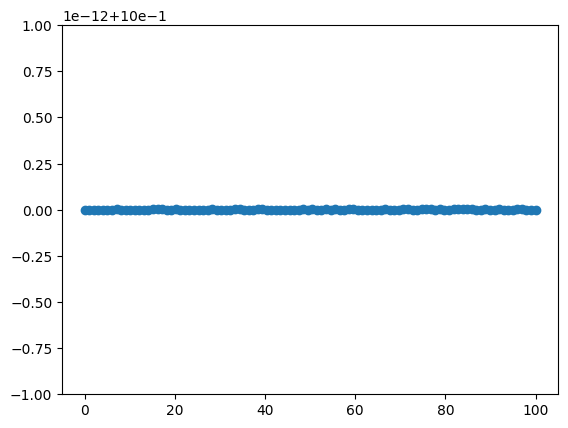

In [61]:
plt.scatter(times, prob, label='Suzuki-order2')

In [ ]:
# z_exp_l_small = circuit_exps(circuits_l_small)
# z_exp_l_large = circuit_exps(circuits_l_large)
# z_exp_l_mid = circuit_exps(circuits_l_mid)
# z_exp_s_large = circuit_exps(circuits_s_large)
z_exp_s_small = circuit_exps(circuits_s_small)
# z_exp_s_large_rep = circuit_exps(circuits_s_large_rep)
# z_exp_s_small_rep = circuit_exps(circuits_s_small_rep)

In [23]:
np.savez('trotter_zzzz_exp.npz', lztr1=z_exp_l_small, lztr3=z_exp_l_mid, lztr10=z_exp_l_large, lzso2r1=z_exp_s_small, lzso6r1=z_exp_s_large, lzso2r10=z_exp_s_small_rep, lzso6r10=z_exp_s_large_rep)

In [ ]:
np.load('trotter_zzzz_exp.npz')['lztr10']

<Axes: xlabel='Time'>

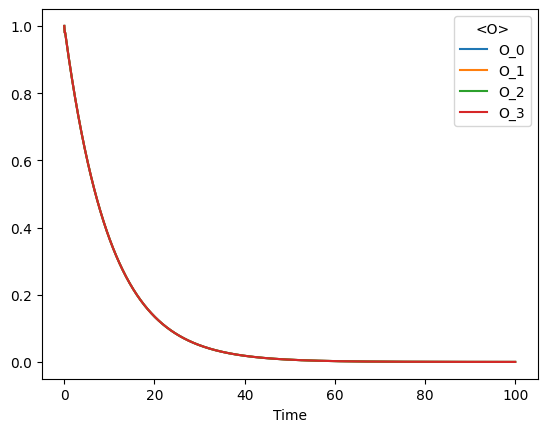

In [51]:
from trotter.hamsimtrotter_scipy import AlgorithmHamSimTrotterCheat
hamiltonian = QubitPauliOperator(
    {
        QubitPauliString(
            [Qubit(0), Qubit(1), Qubit(2), Qubit(3)],
            [Pauli.Z, Pauli.Z, Pauli.I, Pauli.I],
        ): 1,
        QubitPauliString(
            [Qubit(0), Qubit(1), Qubit(2), Qubit(3)],
            [Pauli.I, Pauli.Z, Pauli.Z, Pauli.I],
        ): 1,
        QubitPauliString(
            [Qubit(0), Qubit(1), Qubit(2), Qubit(3)],
            [Pauli.I, Pauli.I, Pauli.Z, Pauli.Z],
        ): 1,
        QubitPauliString(
            [Qubit(0), Qubit(1), Qubit(2), Qubit(3)],
            [Pauli.Z, Pauli.I, Pauli.I, Pauli.Z],
        ): 1,
        QubitPauliString([Qubit(0), Qubit(1), Qubit(2), Qubit(3)], [Pauli.X, Pauli.X, Pauli.X, Pauli.X]): 1,
    }
)
measurements = [QubitPauliOperator({QubitPauliString([Qubit(i)], [Pauli.Z]): 1}) for i in range(4)]
t_max=100
n_trotter_steps = 1000
trotter_time_evolution = AlgorithmHamSimTrotterCheat(Circuit(4),hamiltonian,measurements,t_max,n_trotter_steps)
trotter_time_evolution.execute()
trotter_time_evolution.evolved_measuremets.plot()

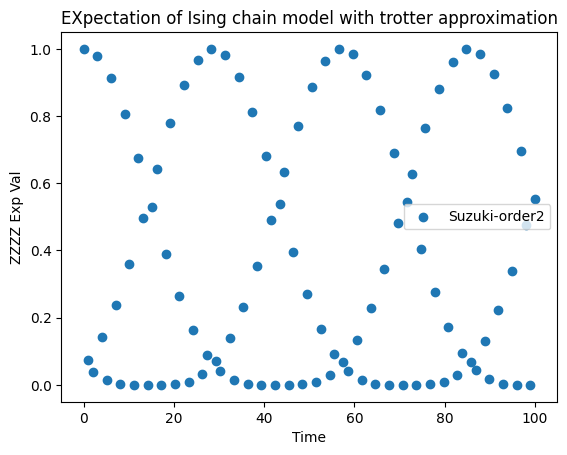

In [49]:
# plt.plot(times, z_exp_l_small, label='Trotter-Rep1')
# plt.plot(times, z_exp_l_mid, label='Trotter-Rep3')
# plt.plot(times, z_exp_l_large, label='Trotter-Rep10')
# plt.plot(times, z_exp_s_large, label='Suzuki-order6')
plt.scatter(times, z_exp_s_small, label='Suzuki-order2')
plt.title('EXpectation of Ising chain model with trotter approximation')
plt.xlabel("Time")
plt.ylabel("ZZZZ Exp Val")
plt.legend()
plt.show()

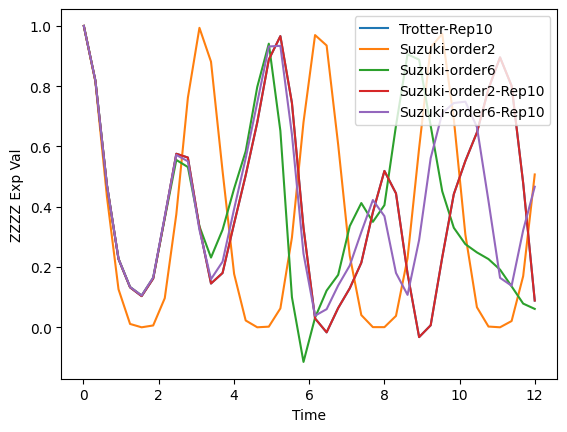

In [25]:
plt.plot(times, z_exp_l_large, label='Trotter-Rep10')
plt.plot(times, z_exp_s_small, label='Suzuki-order2')
plt.plot(times, z_exp_s_large, label='Suzuki-order6')
plt.plot(times, z_exp_s_small_rep, label='Suzuki-order2-Rep10')
plt.plot(times, z_exp_s_large_rep, label='Suzuki-order6-Rep10')

plt.xlabel("Time")
plt.ylabel("ZZZZ Exp Val")
plt.legend()
plt.show()